# Stable Lorenz
By Alan Kaptanoglu

This example builds a data-driven dynamical system model for the Lorenz system, and illustrate the use of the new SINDy extension that searches for stable systems with energy-preserving quadratic nonlinearities. This builds off of the new constrained SINDy algorithm based on SR3. The stability analysis for the Lorenz attractor, as well as the Theorem for stability utilized in this SINDy algorithm, can be found at https://arxiv.org/pdf/1310.0053.pdf.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
import scipy.integrate as integrate 

In [2]:
r = 3
sigma = 10.0
rho = 28.0
beta = 8.0/3.0

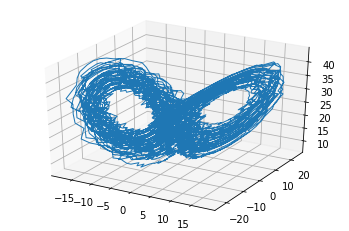

In [3]:
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = (0,1,20)

x_t = integrate.odeint(lorenz_deriv, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
noise = np.random.normal(0,0.5,x_t.shape[0])
for i in range(r):
    x_t[:, i] = x_t[:, i] + noise
    
x, y, z = x_t.T
plt.plot(x, y, z,linewidth=1)

In [4]:
# Custom library order is required for the constraint indexing!
r = 3
poly_order = 2

# Set library functions and names
if poly_order == 2:
   library_functions = [lambda x:x, lambda x, y:x*y, lambda x:x**2]
   library_function_names = [lambda x:x, lambda x, y:x+y, lambda x:x+x]
else:
   library_functions = [lambda x:x]
   library_function_names = [lambda x:x]    
sindy_library = ps.CustomLibrary(library_functions=library_functions,
                                 function_names=library_function_names)

# Since this is noisy data, we need to explicitly constrain the SINDy coefficients
# to have this energy-preserving quadratic structure
q = 0
constraint_zeros = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0)))
constraint_matrix = np.zeros((r + r*(r-1) + int(r*(r-1)*(r-2)/6.0), int(r*(r**2+3*r)/2)))

# Set coefficients adorning terms like a_i^3 to zero
for i in range(r):
    constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r) + i*(r+1)] = 1.0
    q = q + 1

# Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+j-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
        q = q + 1
for i in range(r):
     for j in range(0, i):
        constraint_matrix[q, r*(int((r**2+3*r)/2.0)-r+j)+i] = 1.0
        constraint_matrix[q, r*(r+i-1)+j+r*int(j*(2*r-j-3)/2.0)] = 1.0
        q = q + 1

# Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
for i in range(r):
    for j in range(i+1, r):
        for k in range(j+1, r):
            constraint_matrix[q, r*(r+k-1)+i+r*int(j*(2*r-j-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+k-1)+j+r*int(i*(2*r-i-3)/2.0)] = 1.0
            constraint_matrix[q, r*(r+j-1)+k+r*int(i*(2*r-i-3)/2.0)] = 1.0
            q = q + 1

# Construct the 4-index (constant) PL tensor
Nr = int((r**2 + 3*r)/2.0)
PL_tensor = np.zeros((r, r, r, Nr))
for i in range(r):
    for j in range(r):
        for k in range(r):
            for l in range(Nr):
                if i == l and j == k:
                    PL_tensor[i, j, k, l] = 1.0
                    
# Now symmetrize PL
for i in range(r):
    for j in range(Nr):
        PL_tensor[:, :, i, j] = 0.5 * (PL_tensor[:, :, i, j] + PL_tensor[:, :, i, j].T)
                    
# Construct the 4-index (constant) PQ tensor
PQ_tensor = np.zeros((r, r, Nr))
for i in range(r):
    # Off diagonal terms
    for j in range(i+1, r):
        PQ_tensor[i, j, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = 1.0
            
    # diagonal terms
    PQ_tensor[i, i, Nr - r + i] = 1.0
        
# Now symmetrize PQ
for j in range(Nr):
    PQ_tensor[:, :, j] = 0.5 * (PQ_tensor[:, :, j] + PQ_tensor[:, :, j].T)

# initialize the true m and true P for comparison at the end
m = [0, 0, rho + sigma]
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - i] = m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)      
P_test = PL_tensor - mPQ

[ 0.30344639  0.14958085 38.27876821] 10000
[ 0.43938347  0.15688444 38.52533503] 20000
[ 0.5569778   0.16206649 38.62186892] 30000
[ 0.66598546  0.16641108 38.66700787] 40000
[ 0.76841443  0.17028508 38.6898171 ] 50000
[ 0.8649391   0.17383626 38.70207434] 60000
[ 0.95594979  0.1771353  38.7090879 ] 70000
[ 1.04176549  0.18022077 38.71338417] 80000
[ 1.1226793   0.18311667 38.71621424] 90000
[ 1.19896788  0.18583978 38.71821949] 100000
[ 1.27089339  0.18840309 38.71973955] 110000
[ 1.338704    0.19081743 38.72095999] 120000
[ 1.40263431  0.19309224 38.72198543] 130000
[ 1.4629059   0.19523604 38.72287675] 140000
[ 1.51972786  0.19725663 38.72367056] 150000
[ 1.57329747  0.19916125 38.72438966] 160000
[ 1.62380079  0.20095665 38.72504881] 170000
[ 1.67141326  0.20264914 38.72565793] 180000
[ 1.71630031  0.20424467 38.72622399] 190000
[ 1.75861794  0.2057488  38.7267521 ] 200000
[ 1.7985132   0.2071668  38.72724616] 210000
[ 1.83612475  0.20850359 38.72770927] 220000
[ 1.8715833   0.209

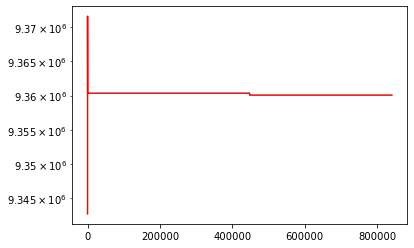

In [128]:
# Put everything in and run the new SINDy algorithm
eta=1.0e-2
alpha_m=1e-1* eta
alpha_A=0.999 * eta
threshold=0.0
sindy_opt = ps.clSR3(threshold=threshold, eta=eta, alpha_m=alpha_m, alpha_A=alpha_A, vtol=1e-6, accel=False,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=500, tol=1e-10,
                           thresholder="l1", eigmin=-1e20, eigmax=-1, 
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature")

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_t, t=t)
print('New SR3: ')
model.print()
Xi = model.coefficients().T
opt_m = sindy_opt.m_history_[-1]
print('optimal m = ', sindy_opt.m_history_[-1])

# reconstruct the P associated with the optimal m
mPQ = np.zeros(PL_tensor.shape)
for i in range(r):
    for j in range(i+1, r):
        mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
for i in range(r):
    mPQ[i, i, :, Nr - r + i] = opt_m
for i in range(r):
    for j in range(Nr):
        mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
P_tensor = PL_tensor - mPQ

# Print the eigenvalues of (PW)_true and (PW)_sindy
As = np.tensordot(P_test, Xi, axes=([3, 2], [0, 1]))
print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print('As eigvals: ', eigvals)
As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
print('As: ', As)
eigvals, eigvecs = np.linalg.eig(As)
print('As eigvals: ', eigvals)

# Plot the objective function history
plt.figure()
plt.semilogy(sindy_opt.objective_history,'r')
sindy_opt.history_ = np.asarray(sindy_opt.history_)

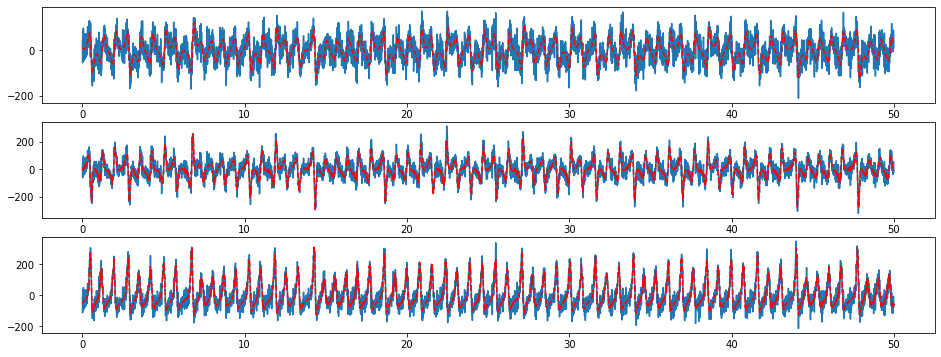

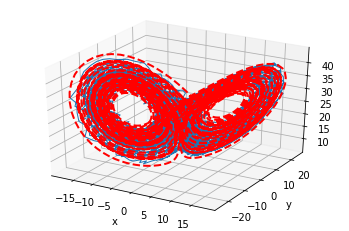

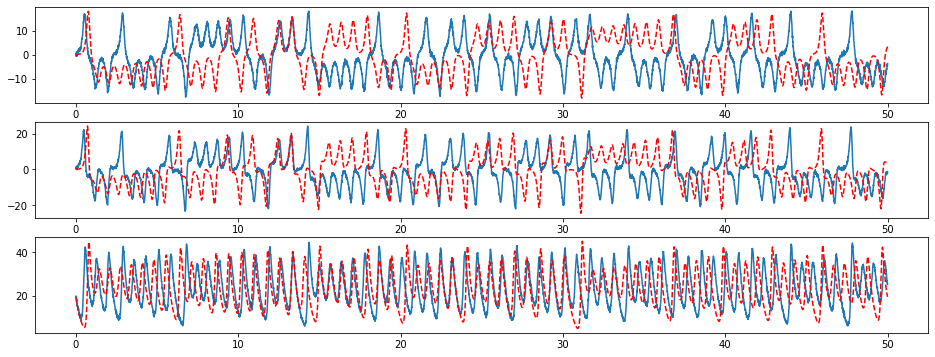

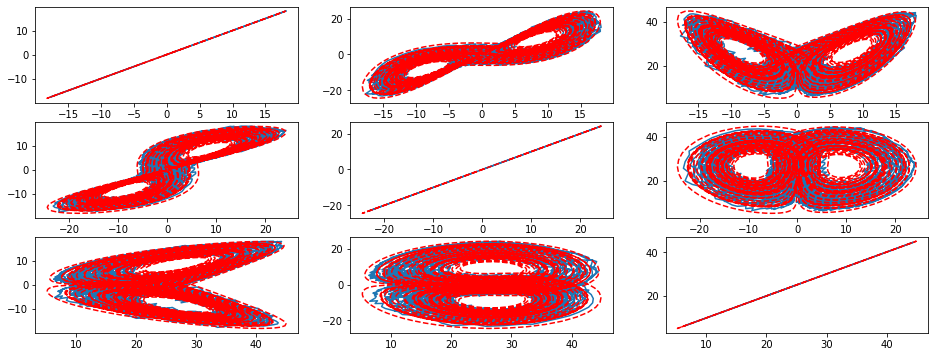

In [129]:
# Plot X and Xdot predictions against the original data
x_dot = model.differentiate(x_t, t=t)
x_dot_pred = model.predict(x_t)
plt.figure(figsize=(16,6))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    plt.plot(t, x_dot[:, i])
    plt.plot(t, x_dot_pred[:, i], 'r--')

tmax = len(t)-1
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
plt.plot(x_t[:,0], x_t[:,1], x_t[:,2],linewidth=1)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['h0'] = 1e-5
x_pred = model.simulate(x_t[0,:], t, integrator_kws=integrator_keywords)
plt.plot(x_pred[:tmax,0], x_pred[:tmax,1], x_pred[:tmax,2], 'r--', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')

plt.figure(figsize=(16,6))
for i in range(r):
    plt.subplot(r, 1, i + 1)
    plt.plot(t, x_t[:, i])
    plt.plot(t, x_pred[:, i], 'r--')
    
plt.figure(figsize=(16,6))
for i in range(r):
    for j in range(r):
        plt.subplot(r, r, i*r + j + 1)
        plt.plot(x_t[:, i], x_t[:, j])
        plt.plot(x_pred[:tmax, i], x_pred[:tmax, j], 'r--')

In [7]:
# Scan the (eta, gamma) model space
Neta = 10
Neig = 10
eta_scan = np.logspace(-2, 3, Neta)
eigmax_scan = np.logspace(-2, 3, Neig)
A_scan = np.zeros((r, Neta, Neig))
Xi_true = np.asarray([[-10.0,28.0,0.],[10.0,-1.0,-0.],[0.,0.,-8.0/3.0],
        [ 0.,0.,1.0],[0.,-1.0,0.],[0.,0.,0.],[0.,0.,0.], [0.,0.,0.], [0.,0.,0.]])
m_true = [0, 0, rho + sigma]
As_true = np.tensordot(P_test, Xi_true, axes=([3, 2], [0, 1]))
Xi_contours = np.zeros((Neta, Neig))
A_contours = np.zeros((Neta, Neig))
Xdot_contours = np.zeros((Neta, Neig))
objectives = []
m_scan = []
X = []
Xdot = []
Xis = []

x0_rand = np.random.rand(3)-0.5
x_test = integrate.odeint(lorenz_deriv, x0_rand, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
noise = np.random.normal(0.0,1.0,x_test.shape[0])
for i in range(r):
    x_test[:,i] = x_test[:,i] + noise
    
for i in range(Neta):
    print(i)
    for j in range(Neig):

        alpha_m = 0.5 * eta_scan[i]
        alpha_A = 0.9 * eta_scan[i]
        sindy_opt = ps.clSR3(threshold=eta_scan[i], eta=1e5, alpha_m=alpha_m, alpha_A=alpha_A, vtol=5e-2, accel=False,
                           PL=PL_tensor, PQ=PQ_tensor, max_iter=20, tol=1e-10,
                           thresholder="l1", eigmin=-1e20, eigmax=-eigmax_scan[j], 
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature")

        model = ps.SINDy(
            optimizer=sindy_opt,
            feature_library=sindy_library,
            differentiation_method=ps.FiniteDifference(drop_endpoints=True),
        )
        
        model.fit(x_t, t=t)
        opt_m = sindy_opt.m_history_[-1]
        Xi = model.coefficients().T
        mPQ = np.zeros(PL_tensor.shape)
        for ii in range(r):
            for jj in range(ii+1, r):
                mPQ[ii, jj, :, int((ii+1)/2.0*(2*r-ii)) + jj - 1 - ii] = opt_m
        for ii in range(r):
            mPQ[ii, ii, :, Nr - r + ii] = opt_m

        for ii in range(r):
            for jj in range(Nr):
                mPQ[:, :, ii, jj] = 0.5 * (mPQ[:, :, ii, jj] + mPQ[:, :, ii, jj].T)    
        P_tensor = PL_tensor - mPQ
        As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
        eigvals, eigvecs = np.linalg.eig(As)
        A_scan[:, i, j] = eigvals
        m_scan.append(opt_m)
        Xi_contours[i, j] = np.linalg.norm(Xi_true-Xi)
        A_contours[i, j] = np.linalg.norm(As_true-As)
        x_dot_pred = model.predict(x_test)
        Xdot_contours[i, j] = np.linalg.norm(x_dot[1:-1,:] - x_dot_pred[1:-1,:])
        x_pred = model.simulate(x0_rand, t, integrator_kws=integrator_keywords)
        Xdot.append(x_dot_pred)
        X.append(x_pred)
        Xis.append(Xi)
        objectives.append(sindy_opt.objective_history)

0
1
2
3
4
5
6
7
8


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduc

9


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,
/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/constrainedlasso_sr3.py:389: ConvergenceWarning: clSR3._reduce did not converge after 20 iterations.
  ConvergenceWarning,


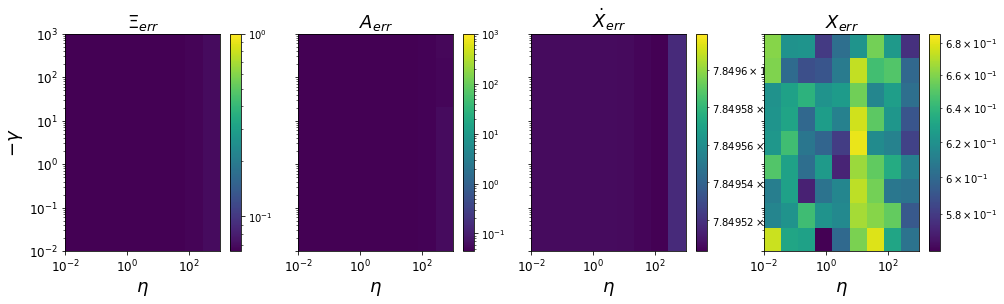

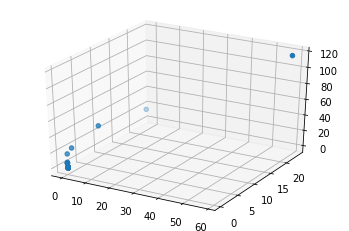

In [8]:
from matplotlib.colors import LogNorm
x_dot = model.differentiate(x_test, t=t)
Xdot = np.asarray(Xdot)
X = np.asarray(X)
Xdot_err = np.zeros((Neta, Neig))
X_err = np.zeros((Neta, Neig))
for i in range(Neta):
    for j in range(Neig):
        Xdot_err[i,j] = np.linalg.norm(Xdot[i*Neig+j, 1:-1, :] - x_dot[1:-1,:])/np.linalg.norm(x_dot[1:-1,:])
        X_err[i,j] = np.linalg.norm(X[i*Neig+j, 1:-1, :] - x_test[1:-1,:])/np.linalg.norm(x_test[1:-1,:])
fs = 18
ts = 12
eta, lam = np.meshgrid(eta_scan, eigmax_scan, indexing='ij')
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.pcolor(eta, lam, Xi_contours/np.linalg.norm(Xi_true), norm=LogNorm(vmin=(Xi_contours/np.linalg.norm(Xi_true)).min(), vmax=1e0))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.ylabel(r'$-\gamma$',fontsize=fs)
plt.title(r'$\Xi_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
plt.subplot(1,4,2)
plt.pcolor(eta, lam, A_contours/np.linalg.norm(As_true), norm=LogNorm(vmin=(A_contours/np.linalg.norm(As_true)).min(), vmax=1e3))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$A_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticklabels([])
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
plt.subplot(1,4,3)
plt.pcolor(eta, lam, Xdot_err,norm=LogNorm(vmin=Xdot_err.min(), vmax=Xdot_err.max()))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$\dot{X}_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])
plt.subplot(1,4,4)
plt.pcolor(eta, lam, X_err,norm=LogNorm(vmin=X_err.min(), vmax=X_err.max()))
plt.xlabel(r'$\eta$',fontsize=fs)
plt.title(r'$X_{err}$',fontsize=fs)
plt.colorbar()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=ts)
ax.tick_params(axis='y', labelsize=ts)
ax.set_yticklabels([])
    
m_scan = np.asarray(m_scan)
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
ax.scatter(m_scan[:,0], m_scan[:,1], m_scan[:,2],marker='o')

0 0.1
[-0.10039013  0.20892608  5.85294619] 10000
[-0.11143254  0.19604327 10.88152052] 20000
[-0.11772505  0.18322829 14.8746775 ] 30000
[-0.12051162  0.17139553 18.05837693] 40000
[-0.12076293  0.16097887 20.61015557] 50000
[-0.11922477  0.15210442 22.66890732] 60000
[-0.11645965  0.14471684 24.34275184] 70000
[-0.1128835   0.13866754 25.71544564] 80000
[-0.1087978   0.13377182 26.8516252 ] 90000
[-0.10441694  0.1298428  27.80106692] 100000
[-0.09989059  0.12670905 28.6021007 ] 110000
[-0.09532125  0.12422193 29.28430018] 120000
[-0.09077771  0.1222569  29.87056938] 130000
[-0.08630495  0.12071191 30.37874022] 140000
[-0.08193133  0.1195044  30.8227842 ] 150000
[-0.07767371  0.11856815 31.21372621] 160000
[-0.0735411   0.11785022 31.56033201] 170000
[-0.06953721  0.11730835 31.86962567] 180000
[-0.06566219  0.1169088  32.14727985] 190000
[-0.06191384  0.11662458 32.39791137] 200000
[-0.05828855  0.11643403 32.62530626] 210000
[-0.05478177  0.11631974 32.83259199] 220000
[-0.0513885  

[ 3.02563652  0.20620535 38.46427205] 90000
[ 3.25017062  0.21126501 38.46739833] 100000
[ 3.45956714  0.21598249 38.47031723] 110000
[ 3.6548594   0.22038128 38.4730425 ] 120000
[ 3.83700856  0.22448322 38.47558697] 130000
[ 4.00690888  0.2283086  38.4779626 ] 140000
[ 4.16539253  0.2318763  38.48018059] 150000
[ 4.31323407  0.23520389 38.48225137] 160000
[ 4.45115458  0.2383077  38.4841847 ] 170000
[ 4.57982543  0.24120294 38.48598968] 180000
[ 4.69987189  0.24390375 38.48767483] 190000
[ 4.81187629  0.24642332 38.48924808] 200000
[ 4.91638113  0.24877391 38.49071687] 210000
New SR3: 
x0' = -10.096 x0 + 10.142 x1 + -0.034 x2 + -0.013 x0x1 + 0.004 x0x2 + -0.007 x1x2 + 0.008 x1x1 + 0.001 x2x2
x1' = 26.207 x0 + -0.065 x1 + -0.005 x2 + -0.008 x0x1 + -0.951 x0x2 + -0.023 x1x2 + 0.013 x0x0
x2' = 0.043 x0 + -0.045 x1 + -2.621 x2 + 0.957 x0x1 + -0.001 x0x2 + -0.004 x0x0 + 0.023 x1x1
optimal m =  [ 4.98075039  0.25022164 38.49162197]
As:  [[-9.93879254 -0.2133275   0.14006867]
 [-0.2133275  -

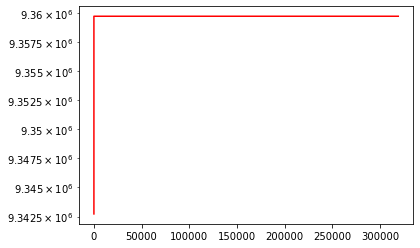

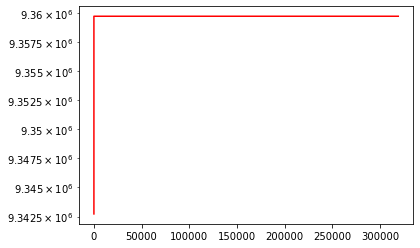

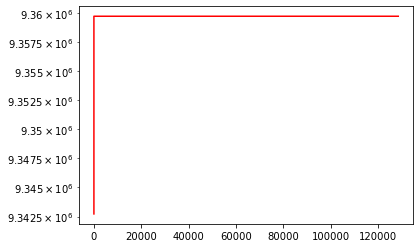

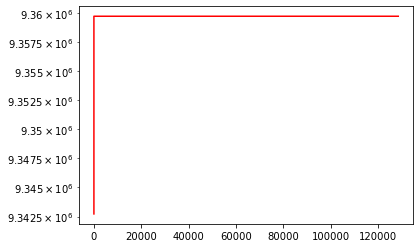

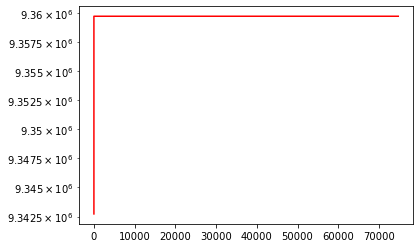

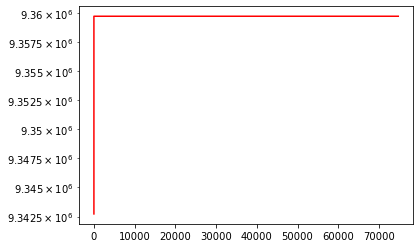

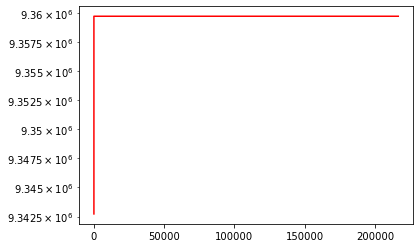

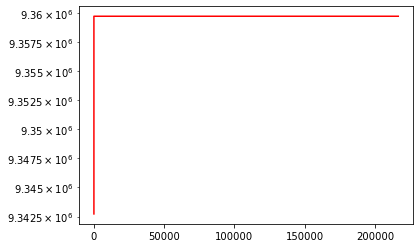

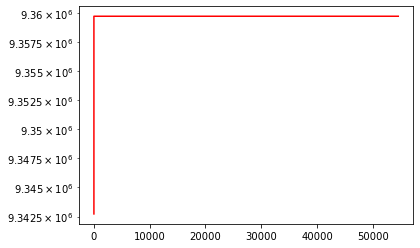

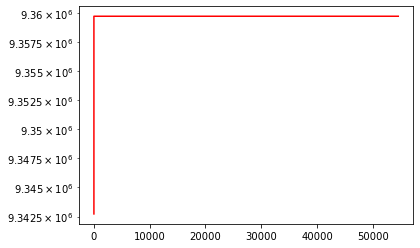

In [133]:
# Look at convergence rates with alpha_m 
eta=1.0e3
alpha_m_scan = np.logspace(-4, 0, 5) * eta
alpha_A=0.5 * eta
threshold_scan = [0.0] #np.logspace(-2, 3, 5)
objective = []
for kk in range(len(threshold_scan)):
    for ii in range(len(alpha_m_scan)):
        print(ii, alpha_m_scan[ii])
        for jj in [False, True]:
            sindy_opt = ps.clSR3(threshold=threshold_scan[kk], eta=eta, alpha_m=alpha_m_scan[ii],
                                       alpha_A=alpha_A, vtol=1e-5, accel=jj,
                                       PL=PL_tensor, PQ=PQ_tensor, max_iter=5000, tol=1e-10,
                                       thresholder="l1", eigmin=-1e20, eigmax=-1, 
                                       constraint_lhs=constraint_matrix,
                                       constraint_rhs=constraint_zeros,
                                       constraint_order="feature")

            model = ps.SINDy(
                optimizer=sindy_opt,
                feature_library=sindy_library,
                differentiation_method=ps.FiniteDifference(drop_endpoints=True),
            )
            model.fit(x_t, t=t)
            print('New SR3: ')
            model.print()
            Xi = model.coefficients().T
            opt_m = sindy_opt.m_history_[-1]
            print('optimal m = ', sindy_opt.m_history_[-1])

            # reconstruct the P associated with the optimal m
            mPQ = np.zeros(PL_tensor.shape)
            for i in range(r):
                for j in range(i+1, r):
                    mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
            for i in range(r):
                mPQ[i, i, :, Nr - r + i] = opt_m
            for i in range(r):
                for j in range(Nr):
                    mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
            P_tensor = PL_tensor - mPQ
            As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
            print('As: ', As)
            eigvals, eigvecs = np.linalg.eig(As)
            print('As eigvals: ', eigvals)
            objective.append(sindy_opt.objective_history)
            # Plot the objective function history
            plt.figure()
            plt.semilogy(sindy_opt.objective_history,'r')
            sindy_opt.history_ = np.asarray(sindy_opt.history_)

(5, 2)


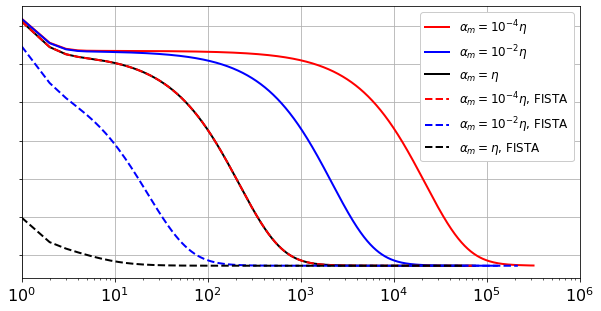

In [134]:
plt.figure(figsize=(10,5))
objective_fun = np.asarray(objective).reshape(2, 5).T
print(objective_fun.shape)
colors = ['r', 'b', 'k', 'm', 'c']
alpha_m_list = [r'$10^{-4}\eta$', r'$10^{-2}\eta$', r'$\eta$']
for jj in range(2):
    for ii in range(len(alpha_m_scan)-2):
    #plt.subplot(1, len(alpha_m_scan), ii + 1)
        k = range(1, len(objective_fun[2 * ii, jj][2:]) + 1, 1)
        if jj == 0:
            # print('do nothing')
            plt.plot(k,objective_fun[2 * ii, jj][2:], color=colors[ii], LineWidth=2, label=r'$\alpha_m = $'+ alpha_m_list[ii])
        else:
            plt.plot(k,objective_fun[2 * ii, jj][2:], color=colors[ii], LineWidth=2, linestyle='--', MarkerSize=5.0, label=r'$\alpha_m = $'+ alpha_m_list[ii] +', FISTA')
    plt.grid(True)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.xlim(1, 1000000)
    plt.legend(loc='upper right', fontsize=12, framealpha=1.0)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.tick_params(axis='x', labelsize=16)
plt.savefig('lorenz_convergence.pdf')


0 0.1
[-0.08090101  0.16400245  5.71382521] 10000
[-0.07801131  0.08997881 10.70592351] 20000
[-7.45194658e-02  9.86743244e-03  1.47195021e+01] 30000
[-0.07059012 -0.06834095 17.94745197] 40000
[-0.06635691 -0.13967487 20.54481321] 50000
[-0.06192852 -0.20137268 22.63625587] 60000
[-0.05739312 -0.25227106 24.32207557] 70000
[-0.05282126 -0.29233531 25.6829899 ] 80000
[-0.04826787 -0.32228904 26.78396484] 90000
[-0.04377357 -0.34331589 27.67725828] 100000
[-0.03936583 -0.35681929 28.40483736] 110000
[-0.0350603  -0.36423686 29.00030451] 120000
[-0.03086249 -0.3669101  29.49044738] 130000
[-2.67698546e-02 -3.66007457e-01  2.98965065e+01] 140000
[-2.27740327e-02 -3.62493447e-01  3.02352297e+01] 150000
[-1.88630553e-02 -3.57131231e-01  3.05197587e+01] 160000
[-1.50232572e-02 -3.50505174e-01  3.07603737e+01] 170000
[-1.12407593e-02 -3.43051679e-01  3.09651117e+01] 180000
[-7.50249528e-03 -3.35090446e-01  3.11402710e+01] 190000
[-3.79682741e-03 -3.26852032e-01  3.12908144e+01] 200000
[-1.138

[21.44638113  3.4026676  32.13710756] 680000
[21.72559838  3.40067757 32.13758256] 690000
[22.00386097  3.39869355 32.13805585] 700000
[22.28117234  3.39671552 32.13852745] 710000
[22.55753589  3.39474346 32.13899736] 720000
[22.83295503  3.39277737 32.13946558] 730000
[23.10743316  3.39081722 32.13993214] 740000
[23.38097363  3.38886299 32.14039702] 750000
[23.65357981  3.38691467 32.14086024] 760000
[23.92525506  3.38497224 32.14132181] 770000
[24.19600271  3.38303569 32.14178173] 780000
[24.46582608  3.38110499 32.14224001] 790000
[24.73472848  3.37918013 32.14269666] 800000
[25.00271321  3.3772611  32.14315167] 810000
[25.26978356  3.37534788 32.14360507] 820000
[25.5359428   3.37344044 32.14405685] 830000
[25.80119419  3.37153878 32.14450702] 840000
[26.06554097  3.36964288 32.14495558] 850000
[26.32898639  3.36775272 32.14540256] 860000
[26.59153366  3.36586829 32.14584794] 870000
[26.85318599  3.36398956 32.14629173] 880000
[27.11394659  3.36211652 32.14673395] 890000
[27.373818

[58.96431845  3.12776335 32.20032091] 2470000
[59.11682379  3.12661345 32.20057577] 2480000
[59.26882091  3.1254671  32.20082977] 2490000
[59.42031155  3.1243243  32.20108291] 2500000
[59.57129745  3.12318504 32.20133519] 2510000
[59.72178037  3.1220493  32.20158662] 2520000
[59.87176202  3.12091707 32.2018372 ] 2530000
[60.02124414  3.11978835 32.20208694] 2540000
[60.17022845  3.11866313 32.20233582] 2550000
[60.31871667  3.11754138 32.20258387] 2560000
[60.46671049  3.11642311 32.20283108] 2570000
[60.61421162  3.1153083  32.20307746] 2580000
[60.76122177  3.11419694 32.203323  ] 2590000
[60.90774261  3.11308903 32.20356772] 2600000
[61.05377583  3.11198454 32.20381161] 2610000
[61.19932311  3.11088348 32.20405467] 2620000
[61.34438612  3.10978583 32.20429692] 2630000
[61.48896653  3.10869157 32.20453835] 2640000
[61.63306599  3.10760071 32.20477896] 2650000
[61.77668615  3.10651323 32.20501877] 2660000
[61.91982868  3.10542911 32.20525776] 2670000
[62.06249519  3.10434836 32.205495

[12.29781089  3.46743517 32.12149996] 370000
[12.60839673  3.46525008 32.12203128] 380000
[12.91791483  3.46307156 32.12256066] 390000
[13.22636906  3.46089958 32.12308812] 400000
[13.53376327  3.45873413 32.12361367] 410000
[13.84010128  3.45657519 32.12413731] 420000
[14.14538693  3.45442274 32.12465905] 430000
[14.449624    3.45227675 32.1251789 ] 440000
[14.7528163   3.45013722 32.12569687] 450000
[15.0549676   3.44800413 32.12621296] 460000
[15.35608165  3.44587745 32.12672718] 470000
[15.65616221  3.44375717 32.12723954] 480000
[15.95521301  3.44164327 32.12775006] 490000
[16.25323775  3.43953573 32.12825872] 500000
[16.55024015  3.43743453 32.12876555] 510000
[16.84622389  3.43533966 32.12927055] 520000
[17.14119264  3.4332511  32.12977372] 530000
[17.43515007  3.43116883 32.13027508] 540000
[17.72809982  3.42909283 32.13077463] 550000
[18.02004553  3.42702309 32.13127238] 560000
[18.3109908   3.42495958 32.13176834] 570000
[18.60093925  3.42290229 32.13226251] 580000
[18.889894

[54.14387134  3.16396838 32.19225814] 2170000
[54.31247111  3.16270667 32.19254038] 2180000
[54.48050699  3.16144886 32.19282166] 2190000
[54.64798093  3.16019492 32.19310198] 2200000
[54.81489488  3.15894485 32.19338135] 2210000
[54.98125078  3.15769863 32.19365977] 2220000
[55.14705057  3.15645626 32.19393723] 2230000
[55.31229617  3.15521772 32.19421376] 2240000
[55.4769895   3.15398301 32.19448934] 2250000
[55.64113248  3.1527521  32.19476399] 2260000
[55.80472702  3.15152499 32.1950377 ] 2270000
[55.967775    3.15030167 32.19531048] 2280000
[56.13027834  3.14908213 32.19558233] 2290000
[56.2922389   3.14786635 32.19585326] 2300000
[56.45365857  3.14665432 32.19612327] 2310000
[56.61453922  3.14544604 32.19639236] 2320000
[56.77488271  3.14424149 32.19666054] 2330000
[56.93469091  3.14304065 32.19692781] 2340000
[57.09396566  3.14184353 32.19719417] 2350000
[57.2527088   3.1406501  32.19745963] 2360000
[57.41092219  3.13946036 32.19772418] 2370000
[57.56860763  3.1382743  32.197987

[19.18682762  3.41875085 32.1332598 ] 60000
[22.0125038   3.39863992 32.13806957] 70000
[24.74305861  3.37912828 32.14270985] 80000
[27.38184766  3.36019903 32.14718729] 90000
[29.93210024  3.34183569 32.15150823] 100000
[32.39692439  3.3240222  32.15567872] 110000
[34.77931179  3.30674291 32.15970454] 120000
[37.0821425   3.28998257 32.16359122] 130000
[39.30818939  3.2737263  32.16734404] 140000
[41.4601225   3.25795963 32.17096805] 150000
[43.54051308  3.24266846 32.17446806] 160000
[45.55183761  3.22783906 32.1778487 ] 170000
[47.49648149  3.21345804 32.18111439] 180000
[49.37674271  3.19951241 32.18426937] 190000
[51.19483526  3.18598948 32.18731768] 200000
[52.95289248  3.17287693 32.19026321] 210000
[54.65297019  3.16016275 32.19310969] 220000
[56.29704973  3.14783527 32.19586068] 230000
[57.88704092  3.13588314 32.19851962] 240000
[59.42478474  3.1242953  32.20108979] 250000
[60.91205609  3.11306102 32.20357434] 260000
[62.35056631  3.10216984 32.20597631] 270000
[63.74196562  

[93.40136558  2.86072513 32.25764952] 660000
[93.78894102  2.85763082 32.25829365] 670000
[94.16415368  2.85463321 32.25891725] 680000
[94.52740204  2.85172933 32.25952097] 690000
[94.87907147  2.84891626 32.26010546] 700000
[95.21953472  2.84619119 32.26067134] 710000
[95.5491523   2.84355138 32.26121921] 720000
[95.86827291  2.84099419 32.26174964] 730000
[96.17723386  2.83851705 32.26226319] 740000
[96.47636142  2.83611748 32.26276042] 750000
[96.76597123  2.83379305 32.26324183] 760000
[97.04636862  2.83154145 32.26370794] 770000
[97.31784898  2.82936038 32.26415925] 780000
[97.58069807  2.82724768 32.26459621] 790000
[97.83519239  2.82520119 32.2650193 ] 800000
[98.08159943  2.82321886 32.26542895] 810000
[98.320178   2.8212987 32.2658256] 820000
[98.55117853  2.81943875 32.26620966] 830000
[98.77484332  2.81763715 32.26658153] 840000
[98.99140683  2.81589207 32.26694161] 850000
[99.20109594  2.81420175 32.26729026] 860000
[99.40413019  2.81256447 32.26762786] 870000
[99.60072202 

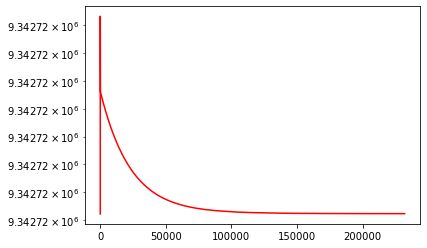

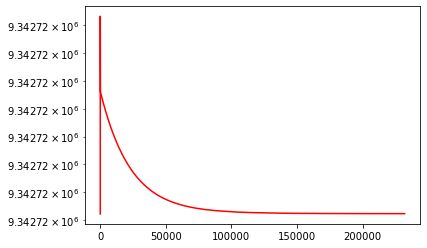

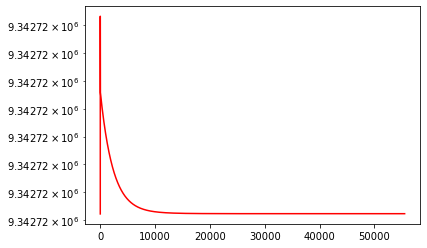

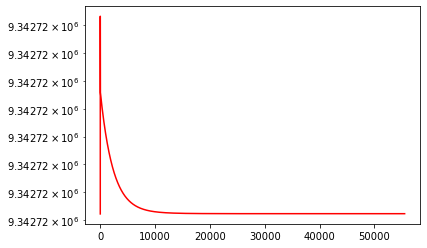

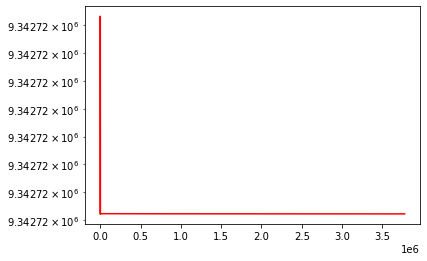

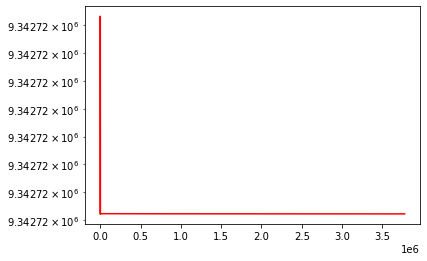

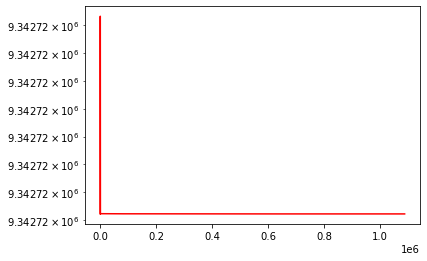

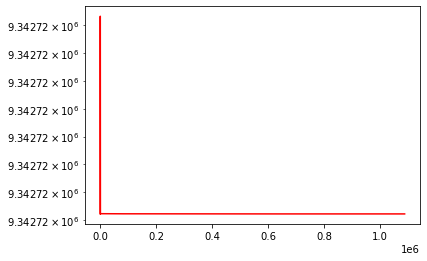

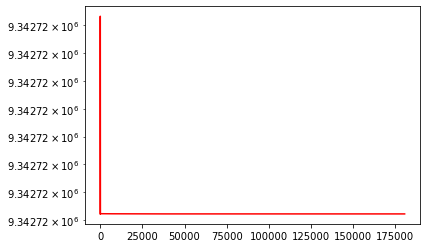

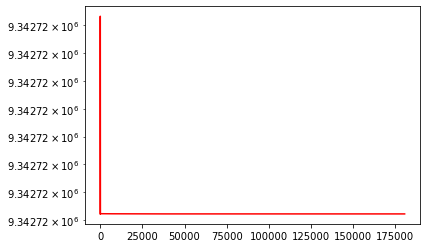

In [130]:
# Look at convergence rates with alpha_m 
eta=1.0e3
alpha_m_scan = np.logspace(-4, 0, 5) * eta
alpha_A=0.5 * eta
threshold_scan = [0.0] #np.logspace(-2, 3, 5)
objective = []
for kk in range(len(threshold_scan)):
    for ii in range(len(alpha_m_scan)):
        print(ii, alpha_m_scan[ii])
        for jj in [False, True]:
            sindy_opt = ps.clSR3(threshold=threshold_scan[kk], eta=eta, alpha_m=alpha_m_scan[ii], w_evo=False,
                                       alpha_A=alpha_A, vtol=1e-5, accel=jj,
                                       PL=PL_tensor, PQ=PQ_tensor, max_iter=5000, tol=1e-10,
                                       thresholder="l1", eigmin=-1e20, eigmax=-1, 
                                       constraint_lhs=constraint_matrix,
                                       constraint_rhs=constraint_zeros,
                                       constraint_order="feature")

            model = ps.SINDy(
                optimizer=sindy_opt,
                feature_library=sindy_library,
                differentiation_method=ps.FiniteDifference(drop_endpoints=True),
            )
            model.fit(x_t, t=t)
            print('New SR3: ')
            model.print()
            Xi = model.coefficients().T
            opt_m = sindy_opt.m_history_[-1]
            print('optimal m = ', sindy_opt.m_history_[-1])

            # reconstruct the P associated with the optimal m
            mPQ = np.zeros(PL_tensor.shape)
            for i in range(r):
                for j in range(i+1, r):
                    mPQ[i, j, :, int((i+1)/2.0*(2*r-i)) + j - 1 - i] = opt_m
            for i in range(r):
                mPQ[i, i, :, Nr - r + i] = opt_m
            for i in range(r):
                for j in range(Nr):
                    mPQ[:, :, i, j] = 0.5 * (mPQ[:, :, i, j] + mPQ[:, :, i, j].T)     
            P_tensor = PL_tensor - mPQ
            As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
            print('As: ', As)
            eigvals, eigvecs = np.linalg.eig(As)
            print('As eigvals: ', eigvals)
            objective.append(sindy_opt.objective_history)
            # Plot the objective function history
            plt.figure()
            plt.semilogy(sindy_opt.objective_history,'r')
            sindy_opt.history_ = np.asarray(sindy_opt.history_)

(5, 2)


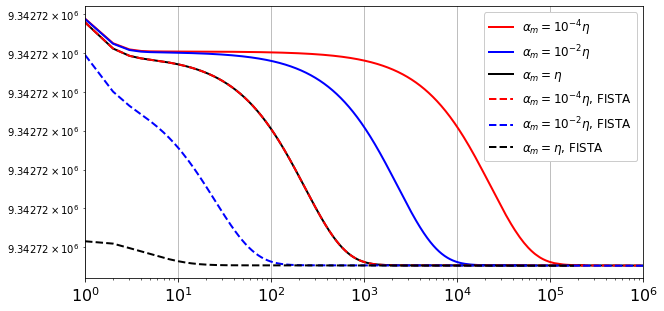

In [131]:
plt.figure(figsize=(10,5))
objective_fun = np.asarray(objective).reshape(2, 5).T
print(objective_fun.shape)
colors = ['r', 'b', 'k', 'm', 'c']
alpha_m_list = [r'$10^{-4}\eta$', r'$10^{-2}\eta$', r'$\eta$']
for jj in range(2):
    for ii in range(len(alpha_m_scan)-2):
    #plt.subplot(1, len(alpha_m_scan), ii + 1)
        k = range(1, len(objective_fun[2 * ii, jj][2:]) + 1, 1)
        if jj == 0:
            # print('do nothing')
            plt.plot(k,objective_fun[2 * ii, jj][2:], color=colors[ii], LineWidth=2, label=r'$\alpha_m = $'+ alpha_m_list[ii])
        else:
            plt.plot(k,objective_fun[2 * ii, jj][2:], color=colors[ii], LineWidth=2, linestyle='--', MarkerSize=5.0, label=r'$\alpha_m = $'+ alpha_m_list[ii] +', FISTA')
    plt.grid(True)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.xlim(1, 1000000)
    plt.legend(loc='upper right', fontsize=12, framealpha=1.0)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='x', labelsize=16)
plt.savefig('lorenz_convergence_Wstatic.pdf')
